In [ ]:
#installing important libraries for processing
!pip install gtfs-kit
!pip install gtfs_functions 
!pip install datashader
!pip install geopy

In [2]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
import gtfs_kit as gk
import gtfs_functions as gtfs
import pandas as pd
#DATASHADER
import datashader as ds
from datashader import transfer_functions as tr_fns
#from datashader.bokeh_ext import InteractiveImage
from functools import partial
#from datashader.bokeh_ext import InteractiveImage
import colorcet as cc
import datashader.transfer_functions as tf

In [3]:
#unpacking the zip file with the gtfs library to DataFrames
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs("GTFS.zip")

Google has a reference file that contains all the information about GTFS files: https://developers.google.com/transit/gtfs/reference
- Routes - This contains information about the whole routes (it's ID, short name that is displayed on the vehicles, and description which in this case contains the first and last stop of the route)
- Stops - Contains information about the stops in the route (It's ID, Name, and location with coordinates (With GPS coordinates that will be useful later))
- Stop_times - Is one of the most useful DataFrames. Information about the stops and the times of arrival and departure (Which can later be used to filter out needed ones)
- Trips - Almost the same as the routes DF but it contains the GPS coordinates of the whole Line (Which will later be useful for finding the lines with 1 transfer)
- Shapes - Shapes contain the Coordinates of all the routes

## Displaying the Dataframes

In [4]:
display("Routes: ",routes,"Stops: ", stops,
        "Stop Times: ", stop_times, 
        "Trips: ", trips,"Shapes: ", shapes)

'Routes: '

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
0,BKK,0050,5,NaN,3,"Pasaréti tér / Rákospalota, Kossuth utca",009EE3,FFFFFF,23
1,BKK,0070,7,NaN,3,"Albertfalva vasútállomás / Újpalota, Nyírpalot...",009EE3,FFFFFF,25
2,BKK,0075,7E,NaN,3,"Blaha Lujza tér M / Újpalota, Nyírpalota út",009EE3,FFFFFF,26
3,BKK,0078,7G,NaN,3,"Cinkotai autóbuszgarázs / Újpalota, Nyírpalota út",009EE3,FFFFFF,27
4,BKK,0085,8E,NaN,3,"Kelenföld vasútállomás M / Újpalota, Nyírpalot...",009EE3,FFFFFF,28
...,...,...,...,...,...,...,...,...,...
345,HEV,H9,H9,NaN,109,Örs vezér tere / Csömör,ED6E86,FFFFFF,9
346,BKK,MP53,M3,NaN,3,Göncz Árpád városközpont M / Kálvin tér M,009EE3,FFFFFF,322
347,BKK,MP531,M3A,NaN,3,Göncz Árpád városközpont M / Nyugati pályaudvar M,009EE3,FFFFFF,323
348,BKK,MP533,M3,NaN,3,Göncz Árpád városközpont M / Kőbánya-Kispest M,009EE3,FFFFFF,321


'Stops: '

,stop_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,003209,Batthyány tér,09001,NaN,NaN,09001,NaN,NaN,POINT (19.03932 47.50678)
1,004903,Örs vezér tere,19795,NaN,NaN,19795,NaN,NaN,POINT (19.13719 47.50359)
2,007736,Gödöllő,19870,NaN,NaN,19870,NaN,NaN,POINT (19.35779 47.59334)
3,007817,Márta utca,NaN,NaN,NaN,NaN,2.0,160,POINT (18.92950 47.42918)
4,007877,Bíróság,NaN,NaN,NaN,NaN,1.0,-78,POINT (18.97806 47.51954)
...,...,...,...,...,...,...,...,...,...
5383,F04834,Tetra Pak,NaN,NaN,NaN,NaN,2.0,-49,POINT (18.90352 47.45783)
5384,F04835,Budaörsi lakótelep,NaN,NaN,NaN,NaN,1.0,56,POINT (18.94090 47.45569)
5385,F04836,Budaörsi lakótelep,NaN,NaN,NaN,NaN,1.0,72,POINT (18.94063 47.45564)
5386,F04837,Lejtő utca,NaN,NaN,NaN,NaN,1.0,-81,POINT (18.93061 47.45961)


'Stop Times: '

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,C0418310,F04181,28980.0,28980.0,0,NaN,NaN,NaN,0.0,8140,...,0,Y701,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
1,C0418310,F04526,29160.0,29160.0,1,NaN,NaN,NaN,160.0,8140,...,0,Y701,"Soroksár, Molnár-sziget",NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10869 47.39824)
2,C0418311,F04526,30600.0,30600.0,0,NaN,NaN,NaN,0.0,8140,...,1,Y702,"Soroksár, Molnár-sziget",NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10869 47.39824)
3,C0418311,F04181,30780.0,30780.0,1,NaN,NaN,NaN,160.0,8140,...,1,Y702,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
4,C0418312,F04181,30780.0,30780.0,0,NaN,NaN,NaN,0.0,8140,...,0,Y701,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810892,H8000_22,F04692,89280.0,89280.0,13,NaN,NaN,NaN,13673.0,H5,...,0,22,"Budakalász, Lenfonó",09191_F04692,NaN,NaN,NaN,NaN,NaN,POINT (19.04691 47.62169)
810893,H8000_22,F04793,89400.0,89400.0,14,NaN,NaN,NaN,14507.0,H5,...,0,22,Szentistvántelep,09209_F04793,NaN,NaN,NaN,NaN,NaN,POINT (19.04316 47.62930)
810894,H8000_22,F04690,89520.0,89580.0,15,NaN,NaN,NaN,16297.0,H5,...,0,22,Pomáz,09134_F04690,NaN,NaN,NaN,NaN,NaN,POINT (19.03203 47.64319)
810895,H8000_22,F04688,89820.0,89820.0,16,NaN,NaN,NaN,19497.0,H5,...,0,22,Pannóniatelep,09217_F04688,NaN,NaN,NaN,NaN,NaN,POINT (19.06529 47.65249)


'Trips: '

,trip_id,route_id,service_id,direction_id,shape_id
0,C0418310,8140,C04183AHPMAA-011,0,Y701
1,C0418311,8140,C04183AHPMAA-011,1,Y702
2,C0418312,8140,C04183AHPMAA-011,0,Y701
3,C0418313,8140,C04183AHPMAA-011,1,Y702
4,C0418314,8140,C04183AHPMAA-011,0,Y701
...,...,...,...,...,...
42373,H550214_1312,H9,20858,0,1312
42374,H550716_1313,H9,20858,1,1313
42375,H55125_1312,H9,20858,0,1312
42376,H55179_1313,H9,20858,1,1313


'Shapes: '

,shape_id,geometry
0,0285,"LINESTRING (19.14833 47.51965, 19.14831 47.519..."
1,0803,"LINESTRING (19.08235 47.55962, 19.08243 47.559..."
2,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
3,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
4,1,"LINESTRING (19.03942 47.50667, 19.03941 47.507..."
...,...,...
1295,Z545,"LINESTRING (19.01851 47.46434, 19.01864 47.464..."
1296,Z546,"LINESTRING (18.92367 47.51776, 18.92387 47.517..."
1297,Z895,"LINESTRING (18.99852 47.49470, 18.99843 47.494..."
1298,Z962,"LINESTRING (19.04937 47.51389, 19.04941 47.513..."


There is a lot of Data with 810897 stops in a 24 hour period. Luckily we only need the 
routes that will get us to the BME I building at 8 o'clock in the morning. We also have the GPS coordinates of all the stops.

Now the first step is to find the GPS coordinates of the I building
which can be found on Google maps:

![I Building](I_building.png)

Next we need to find all the stops that are in a 10 minute walk within the I building. This can differ from person to person but we used a 4km/h walking speed and calculated how many meters can you walk with that speed for 10 minutes time.

The formula for calculating distance is:
$s=v*t$ 
where $s$ is the distance walked and $t$ is the time:
- $4\frac{km}{h}=1,1\frac{m}{s}$
- $10minutes=600seconds$
- $1,1*600=660m$

So the avarage person can walk 600m-s in 10 minutes. Since Google's distance uses birds eye view we used ~600m for the distance.



In [5]:
#variable with I building coordinates
I_building=(47.47282880598328, 19.060057869533754)
radius=(47.46980543001353, 19.05407442774218)

With the geopy library we can calculate the distance between two points so we iterated through the stops and checked wether the fell into this radius

In [6]:
print("stops that are in a 600m radius of Building I at BME: ")
stops_600=[]
for i,k in enumerate(stops["geometry"]):
    if geopy.distance.geodesic(I_building, (k.y,k.x)).m <600.0:
        print("\t-",stops["stop_id"][i])
        stops_600.append(stops["stop_id"][i])

stops that are in a 600m radius of Building I at BME: 
	- 008280
	- 009179
	- 049597
	- 062607
	- 062608
	- 062620
	- 062621
	- 062622
	- 066451
	- 066452
	- 066453
	- 066454
	- 071262
	- F01986
	- F01988
	- F01989
	- F01990
	- F01991
	- F01992
	- F02153
	- F02155
	- F02222
	- F02224
	- F02225


In [7]:
#now we filter stops that are in a 600m radius and reset the index
stops_I=stops[stops["stop_id"].isin(stops_600)]
stops_I.reset_index(drop=True, inplace=True)
display(stops_I)

,stop_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,008280,Infopark (Pázmány Péter sétány),NaN,NaN,NaN,NaN,1.0,179,POINT (19.06433 47.46924)
1,009179,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,-125,POINT (19.05892 47.47680)
2,049597,BudaPart,NaN,NaN,NaN,NaN,1.0,103,POINT (19.05716 47.46844)
3,062607,Infopark (Pázmány Péter sétány),NaN,NaN,NaN,NaN,1.0,-83,POINT (19.06299 47.46985)
4,062608,Magyar tudósok körútja,NaN,NaN,NaN,NaN,1.0,81,POINT (19.06367 47.47147)
5,062620,Egyetemváros - A38 hajóállomás,NaN,NaN,NaN,NaN,1.0,167,POINT (19.06354 47.47329)
6,062621,Egyetemváros - A38 hajóállomás,NaN,NaN,NaN,NaN,1.0,-13,POINT (19.06359 47.47373)
7,062622,Magyar tudósok körútja,NaN,NaN,NaN,NaN,1.0,168,POINT (19.06386 47.47218)
8,066451,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917)
9,066452,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907)


In [8]:
#Next we selected the routes with has stops within a 600m radius of the I building
shapes_within_i=[]
for j,i in enumerate(shapes["geometry"]):
    for k in stops_I["geometry"]:
        if k.x in i.coords.xy[0] and k.y in i.coords.xy[1]:
            shapes_within_i.append(shapes["shape_id"][j])
           

In [9]:
#We filter the shapes with the selected ones
shapes_I=shapes[shapes["shape_id"].isin(shapes_within_i)]
shapes_I.reset_index(drop=True, inplace=True)
display(shapes_I)

,shape_id,geometry
0,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
1,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
2,2064,"LINESTRING (19.07132 47.49604, 19.07127 47.496..."
3,AH19,"LINESTRING (19.06299 47.46985, 19.06299 47.469..."
4,B692,"LINESTRING (19.04835 47.47750, 19.04834 47.477..."
5,B693,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
6,B824,"LINESTRING (19.07134 47.49607, 19.07132 47.496..."
7,BM08,"LINESTRING (19.08126 47.50041, 19.08131 47.500..."
8,BM09,"LINESTRING (19.05793 47.46850, 19.05737 47.468..."
9,DO19,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."


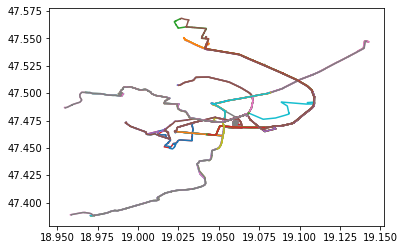

In [10]:
#Lets see how these lines look like (The datashader one will be much better)
for i in shapes_I["geometry"]:
    x,y=i.coords.xy
    plt.plot(x,y)
    plt.scatter(I_building[1], I_building[0])
plt.show()

In [11]:
#Now we filter in the Trips DataFrame becouse it has Route IDs and we drop the duplicates
trips_I=trips[trips["shape_id"].isin(shapes_I["shape_id"])]
trips_I.drop_duplicates(subset=["route_id"])

,trip_id,route_id,service_id,direction_id,shape_id
1446,C34268105116,3060,C34268REHHKMK-011,1,B692
1484,C34268120869,3040,C34268REHHKMK-011,0,0977
7436,C50522131,1530,C50522AHCKVA-011,1,DX77
7440,C505221645,1540,C50522AHCKVA-011,1,RM50
16250,C530791140,9180,C53079AHPMAA-021,1,VN42
18201,C537446103J,3410,C53744AHCPJ-0051,1,TL38
20469,C540151008,1335,C54015TOHCMAA-011,0,SB39
24651,C5450110,1070,C54501AHCWA-0011,0,BM09
31736,C547346553,2120,C54734AHCCsZ-031,1,QH60
31743,C547346581,2121,C54734AHCCsZ-031,0,XD69


In [12]:
#And now we can filter the routes with the route ID so we can have the routes that has stops within a 600m radius of the I building
routes_I=routes[routes["route_id"].isin(trips_I["route_id"])]
routes_I

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
28,BKK,0330,33,NaN,3,"Móricz Zsigmond körtér M / Nagytétény, ipartelep",009EE3,FFFFFF,59
85,BKK,1070,107,NaN,3,BudaPart / Keleti pályaudvar M,009EE3,FFFFFF,158
114,BKK,1335,133E,NaN,3,"Újpalota, Nyírpalota út / Nagytétény, Erdélyi ...",009EE3,FFFFFF,188
135,BKK,1530,153,NaN,3,Infopark (Pázmány Péter sétány) / Gazdagréti tér,009EE3,FFFFFF,209
136,BKK,1540,154,NaN,3,BudaPart / Gazdagréti tér,009EE3,FFFFFF,210
184,BKK,2120,212,NaN,3,"Boráros tér H / Normafa, látogatóközpont",009EE3,FFFFFF,258
185,BKK,2121,212A,NaN,3,Boráros tér H / Svábhegy,009EE3,FFFFFF,259
186,BKK,2122,212B,NaN,3,"Boráros tér H / Csillebérc, KFKI",009EE3,FFFFFF,260
240,BKK,3010,1,NaN,0,Kelenföld vasútállomás M / Bécsi út / Vörösvár...,FFD800,000000,14
246,BKK,3040,4,NaN,0,Széll Kálmán tér M / Újbuda-központ M,FFD800,000000,22


In [13]:
# Now we need filter the stops that are between 7:15 and 7:50 
# (so we still have the 10 minutes to walk to the building)
#The DataFrame stop_times has the times in second so we converted these
stop_7=stop_times[stop_times["arrival_time"]<28200]
stop_7=stop_7[stop_7["arrival_time"]>26100]
stop_7.reset_index(drop=True, inplace=True)

In [14]:
#we have the times and we filter the stops that are in the radius
stop_7_8=stop_7[stop_7["stop_id"].isin(stops_I["stop_id"])]
stop_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
654,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
655,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
672,C3426814107,F02153,27480.0,27480.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
673,C3426814107,F02225,27540.0,27540.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
766,C342682005,F01992,26160.0,26160.0,1,Széll Kálmán tér M,NaN,NaN,546.0,3040,...,1,0976,Budafoki út / Szerémi sor,NaN,NaN,NaN,NaN,1.0,55,POINT (19.05374 47.47409)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,C5478720734,066452,27840.0,27840.0,7,Bécsi út / Vörösvári út,NaN,NaN,3653.0,3010,...,0,N087,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907)
25186,C5478732343,066451,26220.0,26220.0,24,Kelenföld vasútállomás M,NaN,NaN,14504.0,3010,...,1,N088,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917)
25187,C5478732343,066453,26280.0,26280.0,25,Kelenföld vasútállomás M,NaN,NaN,14970.0,3010,...,1,N088,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,-75,POINT (19.05365 47.46981)
25200,C5478732344,066454,27960.0,27960.0,6,Bécsi út / Vörösvári út,NaN,NaN,3181.0,3010,...,0,N087,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,104,POINT (19.05438 47.46965)


In [15]:
#we created a small dictionary to be able to see the stops short names 
# (the ones that we see on the vehicles) and added them to the df
values_dict={"3060":"6", "3040":"4", "1530":"153", "1540":"154", "1335":"133E", '1070':'107', '2120':'212', '2121':"212A",
       '2122':"212B", '0330':"33", '3010':"1"}
short_names=[]
for i in stop_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
stop_7_8["short_names"]=short_names
stop_7_8
    

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
654,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
655,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
672,C3426814107,F02153,27480.0,27480.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
673,C3426814107,F02225,27540.0,27540.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
766,C342682005,F01992,26160.0,26160.0,1,Széll Kálmán tér M,NaN,NaN,546.0,3040,...,0976,Budafoki út / Szerémi sor,NaN,NaN,NaN,NaN,1.0,55,POINT (19.05374 47.47409),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,C5478720734,066452,27840.0,27840.0,7,Bécsi út / Vörösvári út,NaN,NaN,3653.0,3010,...,N087,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907),1
25186,C5478732343,066451,26220.0,26220.0,24,Kelenföld vasútállomás M,NaN,NaN,14504.0,3010,...,N088,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917),1
25187,C5478732343,066453,26280.0,26280.0,25,Kelenföld vasútállomás M,NaN,NaN,14970.0,3010,...,N088,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,-75,POINT (19.05365 47.46981),1
25200,C5478732344,066454,27960.0,27960.0,6,Bécsi út / Vörösvári út,NaN,NaN,3181.0,3010,...,N087,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,104,POINT (19.05438 47.46965),1


In [16]:
#We have the stops but we need the whole Pathways so we filter those with the trip_id
#scince it containts the whole routes
pathways_7_8=stop_times[stop_times["trip_id"].isin(stop_7_8["trip_id"])]


In [44]:
#And we also add the short names to it
short_names=[]
for i in pathways_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
pathways_7_8["short_names"]=short_names
pathways_7_8.reset_index(drop=True, inplace=True)
pathways_7_8.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
0,C34268106997,009220,26400.0,26400.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,B692,Móricz Zsigmond körtér M,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750),6
1,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
2,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
3,C34268106997,F01374,26700.0,26700.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,B692,Boráros tér H,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038),6
4,C34268106997,F01380,26820.0,26820.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,B692,Mester utca / Ferenc körút,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275),6


And now we have all the routes that are between a 7:15-7:50 time period and has stops within a 600m radius of the I building

In [18]:
#saving it ot a csv so we can work with it later
pathways_7_8.to_csv("path_ways_7_8.csv",index=False)

In [64]:
distances=[]
for i in pathways_7_8["geometry"]:
    distances.append(geopy.distance.geodesic(I_building, (k.y,k.x)).m)
pathways_7_8["distances_I"]=distances

AttributeError: 'str' object has no attribute 'y'

Now lets see the datashader heatmap for the routes

In [19]:
#making a df just for the data we need
geometry_x=[]
geometry_y=[]
for i in pathways_7_8["geometry"]:
    geometry_x.append(i.x)
    geometry_y.append(i.y)
              

In [20]:
#print(np.min(geometry_x), np.max(geometry_x)) -> for x_range
#print(np.min(geometry_y), np.max(geometry_y))
BP = x_range, y_range = ((18.954419, 19.142015), (47.387982, 47.548766))
plot_width = int(750)
plot_height = int(plot_width//1.2)
def base_plot(tools='pan, wheel_zoom, reset', plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, outline_line_color=None,
              min_border=0, min_border_left=0, min_border_right=0,
              min_border_top=0, min_border_bottom=0, **plot_args)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
options = dict(line_color=None, fill_color='blue', size=5)

In [32]:
#function to make seconds to hours and minutes
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)


In [33]:
geometry_x_tuple=tuple(geometry_x)
geometry_y_tuple=tuple(geometry_y)
geometry_df=pd.DataFrame({
    'x_coor':geometry_x_tuple,
    'y_coor':geometry_y_tuple,
    'stop_name':pathways_7_8['stop_name']
})


In [34]:
mmt=[]
ido = pathways_7_8['departure_time']
for i in ido:
    mmt.append(convert(i))
geometry_df['get_on'] = mmt

In [35]:
#7:50 is 28200 in seconds
t_to_school=[]
for t in ido:
    t_to_school.append(int((28200-t)/60))
geometry_df['time_to_school']=t_to_school

In [36]:
geometry_df

,x_coor,y_coor,stop_name,get_on,time_to_school
0,19.048349,47.477499,Móricz Zsigmond körtér M,7:20:00,30
1,19.054107,47.475827,Budafoki út / Karinthy Frigyes út,7:22:00,28
2,19.059586,47.476933,"Petőfi híd, budai hídfő",7:23:00,27
3,19.066698,47.480376,Boráros tér H,7:25:00,25
4,19.068848,47.482751,Mester utca / Ferenc körút,7:27:00,23
...,...,...,...,...,...
2254,19.058868,47.536294,Népfürdő utca / Árpád híd,8:22:00,-32
2255,19.045207,47.539593,Szentlélek tér H,8:24:00,-34
2256,19.039960,47.541517,Flórián tér,8:26:00,-36
2257,19.033456,47.545957,Óbudai rendelőintézet,8:27:00,-37


In [120]:
distances=[]
for i,k in zip(geometry_df["x_coor"], geometry_df["y_coor"]):
    distances.append(geopy.distance.geodesic(I_building, (k,i)).m)

In [121]:
norm = [1/(float(i)/sum(distances)) for i in distances]

In [122]:
max(norm)

22800.46621308549

In [123]:
geometry_df["z"]=norm

In [124]:
#import pandas as pd
#!pip install plotly
import plotly.express as px
geometry_df=geometry_df.query('time_to_school>=0')
dff = geometry_df.query('y_coor < 47.548766').query('y_coor > 47.387982').query('x_coor > 18.954419').query('x_coor < 19.142015').query('time_to_school>10')
#bme_i = 47.47277215114886, 19.060034103922074
import plotly
#datashader steps
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(dff, x='x_coor', y='y_coor')
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords['y_coor'].values, agg.coords['x_coor'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

from colorcet import fire
import plotly.graph_objects as go
import datashader.transfer_functions as tf
img = tf.shade(agg, cmap=fire)[::-1].to_pil()

import plotly.express as px
# Trick to create rapidly a figure with mapbox axes
#fig = px.density_mapbox(geometry_df, lat=geometry_df.y_coor, lon= geometry_df.x_coor,zoom=12, hover_name='stop_name', 
#                        hover_data=["x_coor", "y_coor"], radius=5, labels={'get_on':'get_on', 'time_to_school':'time_to_school'})
fig = px.density_mapbox(geometry_df, lat = geometry_df.y_coor, lon = geometry_df.x_coor, z=geometry_df.z,
                        radius=10,
                        center = dict(lat = 47.47277215114886, lon = 19.060034103922074),
                        zoom = 12,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow')


#point to BME
fig.add_trace(go.Scattermapbox(
        lat=[47.47277215114886],
        lon=[19.060034103922074],
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 144, 144)',
            opacity=0.7
        ),
        text=["BME I Epulet"],
    ) )
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

Now the last objective is to find the stops from which you can get to building I in 45 minutes, with a maximum of k transfers, arriving at 8 in the morning.


In [22]:
#Create a list that stores the linestrings of pathways that intercept the stops in the 
# previus DataFrame 
points_with_linestr=[]
for i in shapes["geometry"]:
    for k in pathways_7_8["geometry"]:
        if (i.distance(k)<1e-8) and i not in points_with_linestr:
            #x,y=i.coords.xy
            #points_intercept.append((tuple(x), tuple(y)))
            points_with_linestr.append(i)

In [23]:
# now we filter the shapes with these strings so it only contains the routes 
# that intercept the stops
shapes_intercept=shapes[shapes["geometry"].isin(points_with_linestr)]
shapes_intercept

,shape_id,geometry
2,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
3,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
77,2064,"LINESTRING (19.07132 47.49604, 19.07127 47.496..."
117,7404,"LINESTRING (19.09142 47.47069, 19.09139 47.470..."
126,A776,"LINESTRING (19.00526 47.43212, 19.00518 47.432..."
...,...,...
1292,Z255,"LINESTRING (18.94023 47.45575, 18.94028 47.455..."
1293,Z262,"LINESTRING (19.01378 47.40563, 19.01375 47.405..."
1295,Z545,"LINESTRING (19.01851 47.46434, 19.01864 47.464..."
1296,Z546,"LINESTRING (18.92367 47.51776, 18.92387 47.517..."


In [24]:
#Now find the trips and from that the stops
trips_intercept=trips[trips["shape_id"].isin(shapes_intercept["shape_id"])]
stops_intercept=stop_times[stop_times["trip_id"].isin(trips_intercept["trip_id"])]
stops_intercept

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
15107,C34268105116,009220,25200.0,25200.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,1,B692,Móricz Zsigmond körtér M,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750)
15108,C34268105116,F02153,25320.0,25320.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
15109,C34268105116,F02225,25380.0,25380.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
15110,C34268105116,F01374,25500.0,25500.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,1,B692,Boráros tér H,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038)
15111,C34268105116,F01380,25620.0,25620.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,1,B692,Mester utca / Ferenc körút,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799978,C56119974,F02980,32580.0,32580.0,8,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,4694.0,3014,...,0,TI52,Ajtósi Dürer sor,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.09576 47.51381)
799979,C56119974,F02924,32700.0,32700.0,9,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,5169.0,3014,...,0,TI52,"Erzsébet királyné útja, aluljáró",NaN,NaN,NaN,NaN,1.0,-49,POINT (19.09139 47.51681)
799980,C56119974,F02893,32760.0,32760.0,10,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,5527.0,3014,...,0,TI52,Kacsóh Pongrác út,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.08811 47.51906)
799981,C56119974,F02631,32880.0,32880.0,11,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,6271.0,3014,...,0,TI52,Vágány utca / Róbert Károly körút,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.08099 47.52362)


In [25]:
#and we filter for time from 7:15-7:50 like before
stops_intercept_7_8=stops_intercept[stops_intercept["arrival_time"]<28200]
stops_intercept_7_8=stops_intercept_7_8[stops_intercept_7_8["arrival_time"]>26100]

In [26]:
#and add the short names
values_dict=dict(zip(routes["route_id"], routes["route_short_name"]))
short_names=[]
for i in stops_intercept_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
stops_intercept_7_8["short_names"]=short_names
stops_intercept_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
15118,C34268105116,F01082,26220.0,26220.0,11,Széll Kálmán tér M,NaN,NaN,4773.0,3060,...,B692,Oktogon M,NaN,NaN,NaN,NaN,1.0,-43,POINT (19.06241 47.50594),6
15119,C34268105116,F00933,26340.0,26340.0,12,Széll Kálmán tér M,NaN,NaN,5454.0,3060,...,B692,Nyugati pályaudvar M,NaN,NaN,NaN,NaN,1.0,-56,POINT (19.05617 47.51027),6
15120,C34268105116,F00925,26460.0,26460.0,13,Széll Kálmán tér M,NaN,NaN,6141.0,3060,...,B692,Jászai Mari tér,NaN,NaN,NaN,NaN,1.0,-67,POINT (19.04818 47.51310),6
15121,C34268105116,F00141,26580.0,26580.0,14,Széll Kálmán tér M,NaN,NaN,6621.0,3060,...,B692,Margitsziget / Margit híd,NaN,NaN,NaN,NaN,1.0,-93,POINT (19.04252 47.51472),6
15122,C34268105116,F00192,26640.0,26640.0,15,Széll Kálmán tér M,NaN,NaN,6953.0,3060,...,B692,"Margit híd, budai hídfő H",NaN,NaN,NaN,NaN,1.0,-92,POINT (19.03819 47.51462),6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799486,C5611982,008262,26280.0,26280.0,16,Népliget M,NaN,NaN,9379.0,3014,...,TC22,Hidegkuti Nándor Stadion,NaN,NaN,NaN,NaN,1.0,-180,POINT (19.10891 47.49069),1M
799487,C5611982,008148,26400.0,26400.0,17,Népliget M,NaN,NaN,9955.0,3014,...,TC22,Kőbányai út / Könyves Kálmán körút,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10708 47.48574),1M
799488,C5611982,008146,26460.0,26460.0,18,Népliget M,NaN,NaN,10529.0,3014,...,TC22,Vajda Péter utca,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10317 47.48139),1M
799489,C5611982,F01286,26580.0,26580.0,19,Népliget M,1.0,NaN,11223.0,3014,...,TC22,Népliget M,NaN,NaN,NaN,NaN,1.0,-150,POINT (19.09891 47.47588),1M


In [48]:
pathways_7_8["short_names"].value_counts()

1       640
133E    354
4       323
6       304
33      124
212     114
153     108
107      94
154      92
212A     71
212B     35
Name: short_names, dtype: int64

In [27]:
#and we save this DF too
stops_intercept_7_8.to_csv("stops_that_intercept_7_8.csv")

In [60]:
distances=[]
for i in stops_intercept_7_8["geometry"]:
    distances.append(geopy.distance.geodesic(I_building, (i.y,i.x)).m)

In [61]:
stops_intercept_7_8["distance_I"]=distances

In [62]:
stops_intercept_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names,distance_I
15118,C34268105116,F01082,26220.0,26220.0,11,Széll Kálmán tér M,NaN,NaN,4773.0,3060,...,Oktogon M,NaN,NaN,NaN,NaN,1.0,-43,POINT (19.06241 47.50594),6,3685.454529
15119,C34268105116,F00933,26340.0,26340.0,12,Széll Kálmán tér M,NaN,NaN,5454.0,3060,...,Nyugati pályaudvar M,NaN,NaN,NaN,NaN,1.0,-56,POINT (19.05617 47.51027),6,4173.479026
15120,C34268105116,F00925,26460.0,26460.0,13,Széll Kálmán tér M,NaN,NaN,6141.0,3060,...,Jászai Mari tér,NaN,NaN,NaN,NaN,1.0,-67,POINT (19.04818 47.51310),6,4565.889257
15121,C34268105116,F00141,26580.0,26580.0,14,Széll Kálmán tér M,NaN,NaN,6621.0,3060,...,Margitsziget / Margit híd,NaN,NaN,NaN,NaN,1.0,-93,POINT (19.04252 47.51472),6,4840.997554
15122,C34268105116,F00192,26640.0,26640.0,15,Széll Kálmán tér M,NaN,NaN,6953.0,3060,...,"Margit híd, budai hídfő H",NaN,NaN,NaN,NaN,1.0,-92,POINT (19.03819 47.51462),6,4929.618086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799486,C5611982,008262,26280.0,26280.0,16,Népliget M,NaN,NaN,9379.0,3014,...,Hidegkuti Nándor Stadion,NaN,NaN,NaN,NaN,1.0,-180,POINT (19.10891 47.49069),1M,4183.340634
799487,C5611982,008148,26400.0,26400.0,17,Népliget M,NaN,NaN,9955.0,3014,...,Kőbányai út / Könyves Kálmán körút,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10708 47.48574),1M,3823.744098
799488,C5611982,008146,26460.0,26460.0,18,Népliget M,NaN,NaN,10529.0,3014,...,Vajda Péter utca,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10317 47.48139),1M,3386.421997
799489,C5611982,F01286,26580.0,26580.0,19,Népliget M,1.0,NaN,11223.0,3014,...,Népliget M,NaN,NaN,NaN,NaN,1.0,-150,POINT (19.09891 47.47588),1M,2948.027184
